# Imports

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
!pip install category_encoders ### Uncomment this went running notebook for the first time ###
import category_encoders as ce

# Bring in the CSV's!

In [2]:
# Create the dataframes from the csv's
train = pd.read_csv('../input/train_features.csv')
test = pd.read_csv('../input/test_features.csv')
train_labels = pd.read_csv('../input/train_labels.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')

# Grab the test ids for later

In [3]:
test_ids = test['id']

# Wrangle code with this function(Thanks Ryan Herr)

In [4]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id', 'num_private', 
                         'wpt_name', 'permit', 'management_group',
                         'water_quality', 'year_recorded',
                         'extraction_type_group']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude',
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X

# Gonna slap the labels onto my training df

In [5]:
train['status_group'] = train_labels['status_group']

# Clustering with KMeans! Pretty fancy graphs if I do say so myself!

In [6]:
from sklearn.cluster import KMeans
train['longitude'].values
points = train[['longitude', 'latitude']].fillna(0).values
kmeans = KMeans(n_clusters=14, random_state=42)
kmeans.fit(points)
y_km = kmeans.fit_predict(points)

data = pd.DataFrame({'lon': points[:,0], 'lat': points[:,1], 'cluster':y_km})

train['cluster'] = data['cluster']

# color = data['cluster'].replace({0:'r', 1:'orange', 2:'y', 3:'g',
#                                  4:'b', 5:'indigo', 6:'violet', 7:'black',
#                                  8:'lightblue', 9:'lightgreen', 10:'grey', 
#                                  11:'r', 12:'brown', 13:'brown', 14:'purple',
#                                  15:'black'})


# plt.figure(figsize=(10, 10))
# plt.style.use('ggplot')
# plt.scatter(train['longitude'], train['latitude'], s=2, c = color)
# plt.xlabel('Longitude', fontsize=20)
# plt.ylabel('Latitude', fontsize=20)

# Let's go ahead and cluster those testy bois too

In [7]:
test['longitude'].values
points = test[['longitude', 'latitude']].fillna(0).values
kmeans = KMeans(n_clusters=14)
kmeans.fit(points)
y_km = kmeans.fit_predict(points)

data = pd.DataFrame({'lon': points[:,0], 'lat': points[:,1], 'cluster':y_km})

test['cluster'] = data['cluster']

# Train Validation split!

In [8]:
train, val = train_test_split(train, test_size= test.shape[0], stratify=train['status_group'])

# Use that wrangle function from earlier on the train, validation, and test dataframes! (Thanks again Ryan)

In [9]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Create an X_train, X_val, y_train, y_val, and X_test

In [10]:
X_train = train.drop('status_group', axis=1)
y_train = train['status_group']
X_val = val.drop('status_group', axis=1)
y_val = val['status_group']
X_test = test

# Create pipeline and fit with Random Forest Classifier, can't forget the SimpleImputer and OrdinalEncoder!

In [11]:
rfc = RandomForestClassifier(n_estimators=1000,
                               min_samples_split=6,
                               max_depth = 23,
                               criterion='gini',
                               max_features='auto',
                               random_state=42,
                               n_jobs=-1)

pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    rfc)

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9353936326095644

# Some fancy predictions

In [12]:
y_pred = pipe.predict(X_val)
accuracy_score(y_pred, y_val)

0.820866415935367

# Might as well graph these importances and add an arbitrary vline

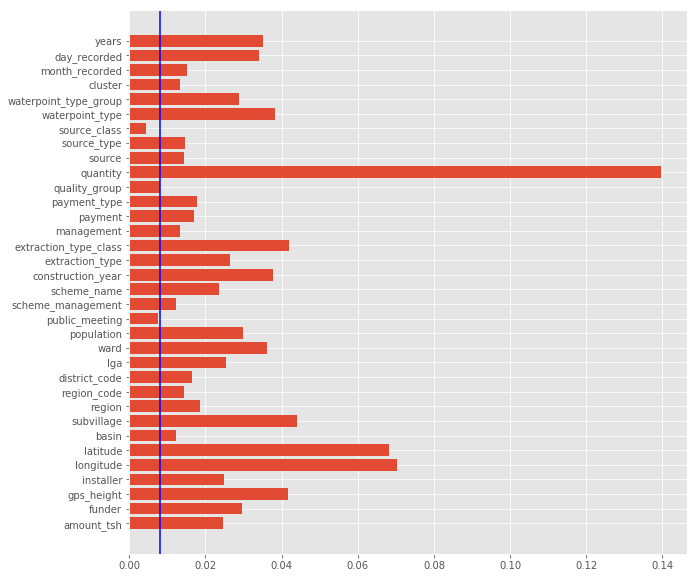

In [13]:
importances = rfc.feature_importances_
features = X_train.columns
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
plt.barh(features, importances)
plt.axvline(.008, c='b')

# Turns out I like the results, let's predict the test features now!

In [14]:
y_pred = pipe.predict(X_test)

In [15]:
y_pred = pipe.predict(X_test)
sub = pd.DataFrame(data = {
    'id': test_ids,
    'status_group': y_pred
})
sub.to_csv('submission.csv', index=False)

# Here's another visualization for the fun of it.

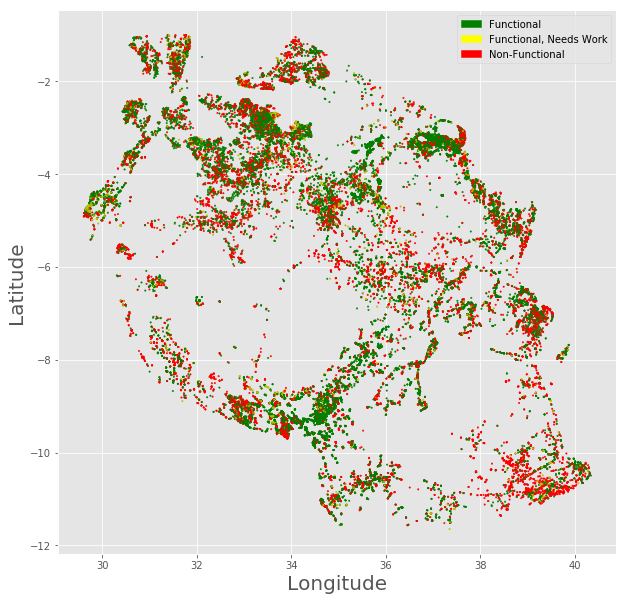

In [16]:
color = train['status_group'].replace({'functional': 'g', 'functional needs repair': 'y', 'non functional': 'r'})
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.scatter(train['longitude'], train['latitude'], s=2, color = color)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
red_patch = mpatches.Patch(color='red', label='Non-Functional')
green_patch = mpatches.Patch(color='green', label='Functional')
yellow_patch = mpatches.Patch(color='yellow', label='Functional, Needs Work')
plt.legend(handles=[green_patch, yellow_patch, red_patch])


In [17]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,construction_year,extraction_type,extraction_type_class,management,payment,payment_type,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,cluster,month_recorded,day_recorded,years
28672,0.0,Adp,NaN,WEDECO,32.750565,-3.917122,Lake Victoria,Ntundu,Shinyanga,17,3,Kahama,Isagehe,NaN,True,VWC,MPEISA,NaN,gravity,gravity,vwc,pay per bucket,per bucket,good,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe,non functional,12,10,3,2012
6909,0.0,Kaemp,NaN,LOCAL CONTRACT,31.580575,-1.410951,Lake Victoria,Bwendangabo,Kagera,18,2,Bukoba Rural,Kaibanja,NaN,True,VWC,NaN,NaN,nira/tanira,handpump,vwc,pay annually,annually,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,3,7,16,2011
10058,30.0,Wateraid,1517.0,SEMA,34.885085,-4.183918,Internal,Kazamoyo,Singida,13,1,Iramba,Mwanga,245.0,True,WUA,Marera water supply,2007.0,mono,motorpump,wua,pay per bucket,per bucket,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,13,1,27,6
53466,0.0,Tasaf,NaN,TASAF,32.991838,-5.289906,Lake Tanganyika,Chang'Ombe,Tabora,14,3,Uyui,Igalula,NaN,True,VWC,NaN,NaN,india mark ii,handpump,vwc,never pay,never pay,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,12,11,12,2012
21600,0.0,Italy Government,NaN,Italy government,33.876357,-3.152493,Lake Victoria,Mwabayanda,Shinyanga,17,2,Maswa,Sukuma,NaN,True,Water authority,Maswa water supply program,NaN,mono,motorpump,vwc,pay annually,annually,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,5,11,5,2012


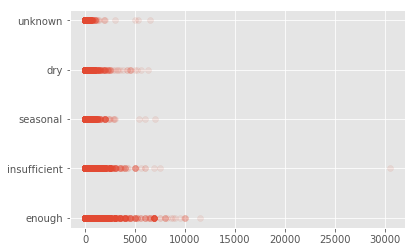

In [18]:
plt.scatter(train['population'], train['quantity'], alpha=.1)
